# Additional Dataset

We combined an [additional dataset](https://www.kaggle.com/edumucelli/spotifys-worldwide-daily-song-ranking) of the 200 daily most streamed Spotify songs to our **tracks** database. Now each track has an additional field of **`score`**: Each time the track made the 200 most streamed list worldwide, its score is **increased by (201 - ranked position)**. The tracks in this additional dataset are matched with our scraped tracks by the trackIDs. Accordingly, each playlist now has an additional field of **`tracks_score`** to be the sum of all its tracks' `score` (0 if none of its tracks made to the 200 most streamed list ever).

In this notebook, we first created a **track-score dictionary {key = trackID, value = score}**, updated this dictionary with our all tracks json database, and update all playlists to have a new field of `tracks_score`. The dataframe of processed playlists with `tracks_score` is saved to a local csv file `playlists_extra.csv`. 

We then fit the same set of regression models on 2 sets of features to predict the number of followers (log-scale) of each playlist. (The following process is almost the same as in Regression Models, except that we use the playlists with additional `tracks_score`.)

- Feature set 1: **main predictors only**
- Feature set 2: **main predictors and interaction terms of (genre X numerical_audio_feature_avg)**

For each set of features, do the following 2 steps:
- Use main predictors only and fit **single** regression models:
    - Linear Regression
    - (Perform PCA on the main predictors and interaction terms set of features)
    - RidgeCV
    - LassoCV
    - Random Forest Regressor
    - Adaboost Regressor

- **Stack** all fitted models on the training set together to fit a
    - **Meta regressor 1: Weighted Average ** 
        - Gather the predicted values of all the fitted single models on the validation set
        - Average each single model's predicted value weighted by its accuracy on the same validation set
    
    - **Meta regressor 2: Meta Linear Regressor ** 
        - Gather the predicted values of all the fitted single models on the validation set
        - Fit a linear regression model on these single models' predicted values

As shown in the **summary** part at the end of this notebook, the addtional dataset **improved** test $R^2$ scores of the **Linear Regression model, RidgeCV, LassoCV** on both sets of features. 5-fold cross-validation of **PCA** on main predictors and the interaction terms selected out one more component (189) than before (188). This suggests the additional dataset did provide some useful information for better prediction of num_followers.

However, test $R^2$ scores of the ensemble regressors (random forest and adaboost; and stacking meta models as a result) do not improve. This may be because the ensemble models' training process include random predictors selection and boostrapping, which already gained enough useful information without the additional dataset. Adding more predictors unnecessarily increased these models' complexity.

In [1]:
# import libraries
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.externals import joblib
from itertools import product
from collections import OrderedDict
from copy import deepcopy
import collections
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Save scraped data to json file
def dump_data(data_to_json, file):
    # example: file = '../data/playlists_5088.json'
    with open(file,'w') as fd:
        json.dump(data_to_json, fd)

# Load json file
def load_data(file):
    with open(file, 'r') as fd:
        data_from_json = json.load(fd)
        return data_from_json

In [3]:
 def extract_track_features(tracks_db, playlists):
    """
    Function to get track features and return a playlist dictionary with track features
    """
    processed_playlists = deepcopy(playlists)
    
    missing_counts = 0
    # Loop over each playlist
    for index, playlist in enumerate(processed_playlists):
        # get the list of track ids for each playlist
        track_ids = playlist['track_ids']
        track_feature_keys = ['acousticness', 'album_id', 'album_name', 'album_popularity','artists_genres', 
                              'artists_ids', 'artists_names', 'artists_num_followers', 'artists_popularities',
                              'avg_artist_num_followers', 'avg_artist_popularity', 'danceability', 'duration_ms',
                              'energy', 'explicit', 'instrumentalness', 'isrc', 'key', 'liveness', 
                              'loudness', 'mode', 'mode_artist_genre', 'name', 'num_available_markets',
                              'popularity', 'speechiness', 'std_artist_num_followers', 'std_artist_popularity',
                              'tempo', 'time_signature', 'valence']
        
        # new entries of audio features for each playlist as a list to append each track's audio feature
        for track_feature_key in track_feature_keys:
            playlist['track_' + track_feature_key] = []
        
        # append each tracks' audio features into the entries of the playlist
        for track_id in track_ids:
            # check if the track_id is in the scrapped_tracks
            if track_id in tracks_db.keys():
                # append each track's audio feature into the playlist dictionary
                for track_feature_key in track_feature_keys:
                    if track_feature_key in tracks_db[track_id].keys():
                        playlist['track_' + track_feature_key].append(tracks_db[track_id][track_feature_key])
            else:
                missing_counts += 1
        processed_playlists[index] = playlist
    print('tracks that are missing : {}'.format(missing_counts))
    return processed_playlists


def build_playlist_dataframe_extra(playlists_dictionary_list):
    """
    Function to build playlist dataframe from playlists dictionary with track features 
    PLUS TRACKS_SCORE
    """
    if playlists_dictionary_list[7914]['id'] == '4krpfadGaaW42C7cEm2O0A':
        del playlists_dictionary_list[7914]
        
    # features to take the avg and std
    features_avg = ['track_acousticness', 'track_avg_artist_num_followers', 'track_album_popularity',
                    'track_avg_artist_popularity', 'track_danceability', 'track_duration_ms', 
                    'track_energy', 'track_explicit', 'track_instrumentalness','track_liveness', 
                    'track_loudness', 'track_mode', 'track_num_available_markets',
                    'track_std_artist_num_followers', 'track_std_artist_popularity',
                    'track_popularity', 'track_speechiness', 'track_tempo', 'track_valence'
                   ]                
                      
    # features to take the mode, # of uniques
    features_mode = ['track_artists_genres','track_key','track_time_signature']

    # features as is
    features = ['collaborative', 'num_followers', 'num_tracks', 'tracks_score']

    processed_playlists = {}

    for index, playlist in enumerate(playlists_dictionary_list):
        playlist_info = {} 
    #     playlist_info['id'] = playlist['id']

        for key in playlist.keys():
            if key in features_avg: # take avg and std
                playlist_info[key + '_avg'] = np.mean(playlist[key])
                playlist_info[key + '_std'] = np.std(playlist[key])
                if key in set(['track_popularity', 'track_album_popularity', 'track_avg_artist_popularity']):
                    playlist_info[key + '_max'] = max(playlist[key])
            elif key in features_mode: # take mode
                if playlist[key]:
                    if key == 'track_artists_genres':
                        flatten = lambda l: [item for sublist in l for item in sublist]
                        flattened_value = flatten(playlist[key])
                        if flattened_value:
                            counter = collections.Counter(flattened_value)
                            playlist_info[key + '_mode'] = counter.most_common()[0][0]
                            playlist_info[key + '_unique'] = len(set(flattened_value))
                    else:
                        counter = collections.Counter(playlist[key])
                        playlist_info[key + '_mode'] = counter.most_common()[0][0]
                        playlist_info[key + '_unique'] = len(set(playlist[key]))
            elif key in features:
                playlist_info[key] = playlist[key]

        processed_playlists[index] = playlist_info
    df = pd.DataFrame(processed_playlists).T
    
    # Drop all observations (playlists) with missingness
    df_full = df.dropna(axis=0, how='any')
    df_full.reset_index(inplace=True, drop=True)
    
    # Define our genre labels
    predefined_genres =['pop rap', 'punk', 'korean pop', 'pop christmas', 'folk', 'indie pop', 'pop', 
                    'rock', 'rap' , 'house', 'indie', 'dance', 'edm', 'mellow', 'hip hop',  
                    'alternative', 'jazz', 'r&b', 'soul', 'reggae', 'classical', 'funk', 'country',
                    'metal', 'blues', 'elect']
    # Create a new column genre_category
    df_full['genre'] = None
    
    # Label genres
    genres = df_full['track_artists_genres_mode']
    for g in reversed(predefined_genres):
        df_full['genre'][genres.str.contains(g)] = g

    # Label all observations that did not match our predefined genres as 'other'  
    df_full['genre'].fillna('other', inplace=True)
    df_full.drop('track_artists_genres_mode', axis=1, inplace=True)
    
    return df_full


def change_column_order(df, col_name, index): 
    """
    Function to change column order in a dataframe
    """
    cols = df.columns.tolist() 
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]


## Extra Dataset Processing

### Build `score` field for each track

In [4]:
extra_df = pd.read_csv('../../data/extra_data.csv')

# Build the filed of Score
extra_df['Track_ID'] = extra_df.URL.str[31:]
extra_df['Score'] = 201 - extra_df['Position']

selected_cols = ['Track_ID', 'Score', 'Streams']
extra_df = extra_df[selected_cols]

# Drop missing values
extra_df.dropna(axis=0, how='any', inplace=True)
print('Is there any missing values in the extra dataset: {}'.format(extra_df.isnull().values.any()))

# Save extra_df to csv file
extra_df_grouped.reset_index(inplace=False)
extra_df_grouped.to_csv('../../data/extra_df.csv')

In [5]:
# Load the extra dataframe
extra_df = pd.read_csv('../../data/extra_df.csv')
extra_df.head()

,Track_ID,Score,Streams
0,000xQL6tZNLJzIrtIgxqSl,388743,188175017
1,000xYdQfIZ4pDmBGzQalKU,11933,8432317
2,007d7JT41sSc1HqWTs4uw7,323,283424
3,009Zz28Vgvnc5FvMXs6dEm,642,4955
4,009j4tQyJC53rmgTuXil9E,26,5234


### Build  `tracks_score` field for each playlist

In [6]:
tracks_score_dict = dict(zip(list(extra_df['Track_ID']), list(extra_df['Score'])))

# Load playlists
playlists = load_data('../../data_archive/playlists_from_200_search_words.json')

# Load tracks
tracks_db = load_data('../../data_archive/tracks.json')

# Add 'tracks_score' to each playlist dictionary
for playlist in playlists:
    tracks_score = 0
    track_ids = playlist['track_ids']
    for track_id in track_ids:
        if track_id in tracks_score_dict:
            tracks_score += tracks_score_dict[track_id]
    playlist['tracks_score'] = tracks_score

### Merge the playlist dataframe with the new `tracks_score` field

In [7]:
processed_playlists = extract_track_features(tracks_db, playlists)
playlists_df_extra = build_playlist_dataframe_extra(processed_playlists)

# Save the new dataframe of playlists
playlists_df_extra.to_csv('../../data/playlists_extra.csv', index=False)

# Load the new dataframe of playlists
playlists_df_extra = pd.read_csv('../../data/playlists_extra.csv')

## Regression models with main predictors only

### Data Processing

Take **log transform** of the skewed response variable:

**`num_followers` -> `log_num_followers`**

In [8]:
# Log transformation
playlists_df_extra['log_num_followers'] = np.log(list(playlists_df_extra['num_followers']+1))

# Dropping the original num_followers, num_tracks
playlists_df_extra.drop(['num_followers'], axis=1, inplace=True)

Take **one-hot** encoding of the categorical variables

In [9]:
# Drop the useless varaible 'collaborative'
playlists_df_extra.drop(['collaborative'], axis=1, inplace=True)
categorical_predictors = ['genre', 'track_time_signature_mode', 'track_key_mode']
numerical_predictors = list(set(playlists_df_extra.columns.values) - set(categorical_predictors))

# One-hot encode categorical features
playlists_df_extra = pd.get_dummies(playlists_df_extra, prefix = categorical_predictors, 
                                         columns = categorical_predictors, drop_first = True)

# Reorder so that the response variable is the last column
playlists_df_extra = change_column_order(playlists_df_extra, 'log_num_followers', len(playlists_df_extra.columns))

playlists_df_extra.head()

,num_tracks,track_acousticness_avg,track_acousticness_std,track_album_popularity_avg,track_album_popularity_max,track_album_popularity_std,track_artists_genres_unique,track_avg_artist_num_followers_avg,track_avg_artist_num_followers_std,track_avg_artist_popularity_avg,...,track_key_mode_3,track_key_mode_4,track_key_mode_5,track_key_mode_6,track_key_mode_7,track_key_mode_8,track_key_mode_9,track_key_mode_10,track_key_mode_11,log_num_followers
0,52,0.180999,0.171120,71.673077,96,13.136445,60,1.276693e+06,1.320843e+06,82.256410,...,0,0,0,0,0,0,0,0,1,14.914325
1,75,0.144201,0.160799,68.440000,100,15.511063,70,3.791621e+06,3.658858e+06,84.684000,...,0,0,0,0,0,0,0,0,0,11.142412
2,38,0.116600,0.117615,72.421053,94,16.192317,44,2.319518e+06,2.237652e+06,86.705263,...,0,0,0,0,0,0,0,0,1,12.863271
3,40,0.134162,0.247197,57.025000,82,18.083815,97,2.387520e+06,3.589807e+06,72.987500,...,0,0,0,1,0,0,0,0,0,11.146849
4,26,0.171635,0.229736,53.461538,54,0.498519,5,8.566853e+04,2.347853e+05,55.059341,...,0,0,0,0,0,0,1,0,0,9.655859


In [10]:
print('Is there any missing values in our new dataset: {}'.format(playlists_df_extra.isnull().values.any()))

Is there any missing values in our new dataset: False


Split data **6:1:1**
1. **train set** for single models: 6/8 of all data
2. **validation set** for single models & **train set for meta models**: 1/8 of all data
3. **test set**: 1/8 of all data

In [11]:
np.random.seed(9001)
msk1 = np.random.rand(len(playlists_df_extra)) < 0.75
playlists_df_train_main = playlists_df_extra[msk1]
playlists_df_nontrain_main = playlists_df_extra[~msk1]

msk12 = np.random.rand(len(playlists_df_nontrain_main)) < 0.5
playlists_df_valid_main = playlists_df_nontrain_main[msk12]
playlists_df_test_main = playlists_df_nontrain_main[~msk12]

In [12]:
# Build predictors & response
X_train_main = playlists_df_train_main.iloc[:,:-1]
X_valid_main = playlists_df_valid_main.iloc[:,:-1]
X_test_main = playlists_df_test_main.iloc[:,:-1]

y_train = playlists_df_train_main['log_num_followers']
y_valid = playlists_df_valid_main['log_num_followers']
y_test = playlists_df_test_main['log_num_followers']

X_train_main.shape, y_train.shape, X_valid_main.shape, y_valid.shape, X_test_main.shape, y_test.shape

((7083, 86), (7083,), (1214, 86), (1214,), (1133, 86), (1133,))

Drop columns that have only 0 and **standardize** numerical variables using **train set's mean and std**

In [13]:
for col in X_train_main.columns:
    if (X_train_main[col] == 0).all():
        X_train_main.drop(col, axis=1, inplace=True)
    else:
        # Standardize a numerical variable
        if not np.logical_or((X_train_main[col]==0), ((X_train_main[col]==1))).all():
            mean_train = X_train_main[col].mean()
            std_train = X_train_main[col].std()
            X_train_main[col] = (X_train_main[col] - mean_train) / std_train
            X_valid_main[col] = (X_valid_main[col] - mean_train) / std_train
            X_test_main[col] = (X_test_main[col] - mean_train) / std_train


### Regression Models

#### Linear regression

In [14]:
# Fit & Save model
sim_lin_main = LinearRegression().fit(X_train_main, y_train)
joblib.dump(sim_lin_main, '../../fitted_models_extra/sim_lin_main.pkl') 

In [15]:
# Load fitted model to reproduce results
sim_lin_main = joblib.load('../../fitted_models_extra/sim_lin_main.pkl') 
print('-- Linear Regression with all main predictors only --')
print('Training R^2: ', sim_lin_main.score(X_train_main, y_train))
print('Test R^2: ', sim_lin_main.score(X_test_main, y_test))

-- Linear Regression with all main predictors only --
Training R^2:  0.274574920284
Test R^2:  0.256241949862


#### RidgeCV

In [16]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
ridge_cv_main = RidgeCV(alphas=lambdas, fit_intercept=True).fit(X_train_main, y_train)
joblib.dump(ridge_cv_main, '../../fitted_models_extra/ridge_cv_main.pkl') 

In [17]:
# Load fitted model
ridge_cv_main = joblib.load('../../fitted_models_extra/ridge_cv_main.pkl') 
ridge_r2_train_main = ridge_cv_main.score(X_train_main, y_train)
ridge_r2_test_main = ridge_cv_main.score(X_test_main, y_test)

print('-- RidgeCV (best alpha = {}) with all main predictors only --'.format(ridge_cv_main.alpha_))
print("Training R^2: {}".format(ridge_r2_train_main))
print("Test R^2: {}".format(ridge_r2_test_main))

-- RidgeCV (best alpha = 10.0) with all main predictors only --
Training R^2: 0.274174747409772
Test R^2: 0.25463769616193843


#### LassoCV 

In [18]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
lasso_cv_main = LassoCV(alphas=lambdas, fit_intercept=True).fit(X_train_main, y_train)
joblib.dump(lasso_cv_main, '../../fitted_models_extra/lasso_cv_main.pkl') 

In [19]:
# Load fitted model
lasso_cv_main = joblib.load('../../fitted_models_extra/lasso_cv_main.pkl') 
lasso_r2_train_main = lasso_cv_main.score(X_train_main, y_train)
lasso_r2_test_main = lasso_cv_main.score(X_test_main, y_test)

print('-- LassoCV (best alpha = {}) with all main predictors only --'.format(lasso_cv_main.alpha_))
print("Training R^2: {}".format(lasso_r2_train_main))
print("Test R^2: {}".format(lasso_r2_test_main))

-- LassoCV (best alpha = 0.01) with all main predictors only --
Training R^2: 0.2668177814282259
Test R^2: 0.2539347727528575


#### Random Forest

In [20]:
RF_params = OrderedDict(
    n_estimators = [2**(i+2) for i in np.arange(7)],
    max_features = [0.1, 0.3, 0.5, 0.7, 0.9]
)
RF_params.values()

odict_values([[4, 8, 16, 32, 64, 128, 256], [0.1, 0.3, 0.5, 0.7, 0.9]])

In [21]:
# Use 5-fold validation to find the optimal n_estimators and max_features for Random Forest Regression
cv_scores_RF_main = []
params_dict_RF_main = {}

for i, (n, f) in enumerate(product(*RF_params.values())):
    params_dict_RF_main[i] = (n, f)
    
    # Cross Validation on Random Forest Classifier
    RF_main = RandomForestRegressor(oob_score=False, n_estimators=n, max_features=f, n_jobs=-1, random_state=22)
    scores = cross_val_score(RF_main, X_train_main, y_train, cv=5, scoring='r2')
    cv_scores_RF_main.append(scores.mean())

# Get the optimal set of parameters of the Random Forest Regressor
idx_optimal = np.argmax(cv_scores_RF_main)
optimal_params_RF_main = params_dict_RF_main[idx_optimal]
print('-- Random Forest Regression with all main predictors only --')
print('Maximum R^2 validation score = {}'.format(max(cv_scores_RF_main)))
print('Optimal n_estimators = {}'.format(optimal_params_RF_main[0]))
print('Optimal max_features = {}'.format(optimal_params_RF_main[1]))

# Fit the best RF
RF_best_main = RandomForestRegressor(oob_score=False, n_estimators=optimal_params_RF_main[0], 
                                     max_features=optimal_params_RF_main[1], n_jobs=-1, 
                                     random_state=22).fit(X_train_main, y_train)
RF_best_r2_train_main = RF_best_main.score(X_train_main, y_train)
RF_best_r2_test_main = RF_best_main.score(X_test_main, y_test)
print('-- Best Random Forest Regression --')
print("Training R^2: {}".format(RF_best_r2_train_main))
print("Test R^2: {}".format(RF_best_r2_test_main))

# Dump fitted model to disk
joblib.dump(RF_best_main, '../../fitted_models_extra/RF_best_main.pkl') 

Load fitted model to reproduce results directly

In [22]:
# Load fitted model to reproduce results
RF_best_main = joblib.load('../../fitted_models_extra/RF_best_main.pkl') 
RF_best_r2_train_main = RF_best_main.score(X_train_main, y_train)
RF_best_r2_test_main = RF_best_main.score(X_test_main, y_test)
print('-- Best Random Forest Regression with all main predictors only --')
print("Training R^2: {}".format(RF_best_r2_train_main))
print("Test R^2: {}".format(RF_best_r2_test_main))

-- Best Random Forest Regression with all main predictors only --
Training R^2: 0.9260804564458209
Test R^2: 0.47225563755064515


#### Adaboost Regression

In [23]:
ab_params = OrderedDict(
    base_depths = [2, 4, 6, 8],
    n_estimators = [2**(i+2) for i in np.arange(7)]
)
ab_params.values()

odict_values([[2, 4, 6, 8], [4, 8, 16, 32, 64, 128, 256]])

In [24]:
# Use 5-fold CV to choose max_depth & n_estimators in AdaBoost Regressor
l_rate = 0.05
params_dict_ab_main = {}
cv_scores_ab_main = []
for i, (d, n) in enumerate(product(*ab_params.values())):
    params_dict_ab_main[i] = (d, n)
    ab_main = AdaBoostRegressor(DecisionTreeRegressor(max_depth=d, random_state=22), n_estimators=n, 
                                learning_rate=l_rate, random_state=22)
    scores = cross_val_score(ab_main, X_train_main, y_train, cv=5, scoring='r2')
    cv_scores_ab_main.append(scores.mean())


# Get the optimal set of parameters of the Random Forest Regressor
idx_optimal = np.argmax(cv_scores_ab_main)
optimal_params_ab_main = params_dict_ab_main[idx_optimal]
print('-- AdaBoost Regression with all main predictors only --')
print('Maximum R^2 cv score = {}'.format(max(cv_scores_ab_main)))
print('Optimal base tree max_depth = {}'.format(optimal_params_ab_main[0]))
print('Optimal n_estimators = {}'.format(optimal_params_ab_main[1]))

# Fit the best Adaboost regressor
ab_best_main = AdaBoostRegressor(DecisionTreeRegressor(max_depth=optimal_params_ab_main[0], random_state=22), 
                                 n_estimators=optimal_params_ab_main[1], learning_rate=l_rate, 
                                 random_state=22).fit(X_train_main, y_train)

ab_best_r2_train_main = ab_best_main.score(X_train_main, y_train)
ab_best_r2_test_main = ab_best_main.score(X_test_main, y_test)
print('-- Best AdaBoost Regression --')
print("Training R^2: {}".format(ab_best_r2_train_main))
print("Test R^2: {}".format(ab_best_r2_test_main))

# Dump fitted model to disk
joblib.dump(ab_best_main, '../../fitted_models_extra/ab_best_main.pkl') 

Load fitted model to reproduce results directly

In [25]:
# Load fitted model to reproduce results
ab_best_main = joblib.load('../../fitted_models_extra/ab_best_main.pkl') 
ab_best_r2_train_main = ab_best_main.score(X_train_main, y_train)
ab_best_r2_test_main = ab_best_main.score(X_test_main, y_test)
print('-- Best AdaBoost Regression with all main predictors only --')
print("Training R^2: {}".format(ab_best_r2_train_main))
print("Test R^2: {}".format(ab_best_r2_test_main))

-- Best AdaBoost Regression with all main predictors only --
Training R^2: 0.6621121188291732
Test R^2: 0.41227040525395264


#### Meta Model: Weighted Avg

In [26]:
prefix = '../../fitted_models_extra/'
suffix = '.pkl'
models_main = ['sim_lin_main', 'ridge_cv_main', 'lasso_cv_main', 'RF_best_main', 'ab_best_main']

# Record model's r2 score and predicted results on validation set
weights_main = np.zeros((len(models_main),))
preds_main_valid = np.zeros((y_valid.shape[0], len(models_main)))
preds_main_test = np.zeros((y_test.shape[0], len(models_main)))
for i, name in enumerate(models_main):
    model_name = prefix + name + suffix
    model = joblib.load(model_name) 
    weights_main[i] = model.score(X_valid_main, y_valid)
    preds_main_valid[:, i] = model.predict(X_valid_main)
    preds_main_test[:, i] = model.predict(X_test_main)

weights_main = weights_main/np.sum(weights_main)
meta_pred_main_valid = np.average(preds_main_valid, axis=1, weights=weights_main)
meta_pred_main_test = np.average(preds_main_test, axis=1, weights=weights_main)

meta_r2_valid_main = r2_score(y_valid, meta_pred_main_valid)
meta_r2_test_main = r2_score(y_test, meta_pred_main_test)
print('-- Meta model 1: Weighted Avg with all main predictors only --')
print("Valid (Meta Train) R^2: {}".format(meta_r2_valid_main))
print("Test R^2: {}".format(meta_r2_test_main))

-- Meta model 1: Weighted Avg with all main predictors only --
Valid (Meta Train) R^2: 0.40880273711359416
Test R^2: 0.40446925924097


#### Meta Model: Linear Regression

In [27]:
# Record model's predicted results on validation set as the train set for the meta regressor
meta_X_train_main = np.zeros((y_valid.shape[0], len(models_main)))
meta_X_test_main = np.zeros((y_test.shape[0], len(models_main)))
for i, name in enumerate(models_main):
    model_name = prefix + name + suffix
    model = joblib.load(model_name) 
    meta_X_train_main[:, i] = model.predict(X_valid_main)
    meta_X_test_main[:, i] = model.predict(X_test_main)

meta_reg_main = LinearRegression().fit(meta_X_train_main, y_valid)
joblib.dump(meta_reg_main, '../../fitted_models_extra/meta_reg_main.pkl') # Dump fitted model to disk

# Load fitted model to reproduce results
meta_reg_main = joblib.load('../../fitted_models_extra/meta_reg_main.pkl') 
print('-- Meta model 2: Linear Regression with all main predictors only --')
print("Train R^2: {}".format(meta_reg_main.score(meta_X_train_main, y_valid)))
print("Test R^2: {}".format(meta_reg_main.score(meta_X_test_main, y_test)))

-- Meta model 2: Linear Regression with all main predictors only --
Train R^2: 0.4872242995695527
Test R^2: 0.48532625439707866


## Regression models with main predictors & interaction terms

### Data Processing

Add interaction terms between **genres** and the **numerical audio features' average**

In [28]:
audio_features_avg = ['track_acousticness_avg', 'track_album_popularity_avg', 'track_danceability_avg',
                    'track_duration_ms_avg', 'track_energy_avg', 'track_explicit_avg', 
                    'track_instrumentalness_avg', 'track_liveness_avg', 'track_loudness_avg', 'track_mode_avg', 
                    'track_speechiness_avg', 'track_tempo_avg', 'track_valence_avg']
genres = ['genre_blues', 'genre_classical', 'genre_country', 'genre_dance',
       'genre_edm', 'genre_elect', 'genre_folk', 'genre_funk', 'genre_hip hop',
       'genre_house', 'genre_indie', 'genre_indie pop', 'genre_jazz',
       'genre_korean pop', 'genre_mellow', 'genre_metal', 'genre_other',
       'genre_pop', 'genre_pop christmas', 'genre_pop rap', 'genre_punk',
       'genre_r&b', 'genre_rap', 'genre_reggae', 'genre_rock', 'genre_soul',]

cross_terms = audio_features_avg + genres

In [29]:
# Make a copy of the raw playlists dataframe with extra dataset info
playlists_df_interaction = deepcopy(playlists_df_extra)

# Generate 2-way interaction terms
for feature in audio_features_avg:
    for genre in genres:
        playlists_df_interaction[feature+'_X_'+genre] = playlists_df_extra[feature] * playlists_df_extra[genre]

playlists_df_interaction = change_column_order(playlists_df_interaction, 'log_num_followers', len(playlists_df_interaction.columns))
playlists_df_interaction.head()

,num_tracks,track_acousticness_avg,track_acousticness_std,track_album_popularity_avg,track_album_popularity_max,track_album_popularity_std,track_artists_genres_unique,track_avg_artist_num_followers_avg,track_avg_artist_num_followers_std,track_avg_artist_popularity_avg,...,track_valence_avg_X_genre_pop,track_valence_avg_X_genre_pop christmas,track_valence_avg_X_genre_pop rap,track_valence_avg_X_genre_punk,track_valence_avg_X_genre_r&b,track_valence_avg_X_genre_rap,track_valence_avg_X_genre_reggae,track_valence_avg_X_genre_rock,track_valence_avg_X_genre_soul,log_num_followers
0,52,0.180999,0.171120,71.673077,96,13.136445,60,1.276693e+06,1.320843e+06,82.256410,...,0.456071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.914325
1,75,0.144201,0.160799,68.440000,100,15.511063,70,3.791621e+06,3.658858e+06,84.684000,...,0.555027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.142412
2,38,0.116600,0.117615,72.421053,94,16.192317,44,2.319518e+06,2.237652e+06,86.705263,...,0.526526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.863271
3,40,0.134162,0.247197,57.025000,82,18.083815,97,2.387520e+06,3.589807e+06,72.987500,...,0.501825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.146849
4,26,0.171635,0.229736,53.461538,54,0.498519,5,8.566853e+04,2.347853e+05,55.059341,...,0.658846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.655859


Split data **6:1:1**
1. **train set** for single models: 6/8 of all data
2. **validation set** for single models & **train set for meta models**: 1/8 of all data
3. **test set**: 1/8 of all data

In [30]:
# Split data into train & test set
np.random.seed(9001)
msk2 = np.random.rand(len(playlists_df_interaction)) < 0.75
playlists_df_train_int = playlists_df_interaction[msk2]
playlists_df_nontrain_int = playlists_df_interaction[~msk2]

msk22 = np.random.rand(len(playlists_df_nontrain_int)) < 0.5
playlists_df_valid_int = playlists_df_nontrain_int[msk22]
playlists_df_test_int = playlists_df_nontrain_int[~msk22]

In [31]:
# Build predictors & response
X_train_int = playlists_df_train_int.iloc[:,:-1]
X_valid_int = playlists_df_valid_int.iloc[:,:-1]
X_test_int = playlists_df_test_int.iloc[:,:-1]

X_train_int.shape, y_train.shape, X_valid_int.shape, y_valid.shape, X_test_int.shape, y_test.shape

((7083, 424), (7083,), (1214, 424), (1214,), (1133, 424), (1133,))

Drop columns that have only 0 and **standardize** numerical variables using **train set's mean and std**

In [32]:
for col in X_train_int.columns:
    if (X_train_int[col] == 0).all():
        X_train_int.drop(col, axis=1, inplace=True)
    else:
        # Standardize a numerical variable
        if not np.logical_or((X_train_int[col]==0), ((X_train_int[col]==1))).all():
            mean_train = X_train_int[col].mean()
            std_train = X_train_int[col].std()
            X_train_int[col] = (X_train_int[col] - mean_train) / std_train
            X_valid_int[col] = (X_valid_int[col] - mean_train) / std_train
            X_test_int[col] = (X_test_int[col] - mean_train) / std_train


### Regression Models

#### Linear regression

In [33]:
# Fit & Save Model
sim_lin_int = LinearRegression().fit(X_train_int, y_train)
joblib.dump(sim_lin_int, '../../fitted_models_extra/sim_lin_int.pkl') 

In [34]:
# Load fitted model to reproduce results
sim_lin_int = joblib.load('../../fitted_models_extra/sim_lin_int.pkl') 
print('-- Linear Regression with main predictors and interaction terms --')
print('Training R^2: ', sim_lin_int.score(X_train_int, y_train))
print('Test R^2: ', sim_lin_int.score(X_test_int, y_test))

-- Linear Regression with main predictors and interaction terms --
Training R^2:  0.334319723639
Test R^2:  0.249699128912


#### Perform PCA on main predictors & their interaction terms
Use 5-Fold cross-validation to find the best n_components of PCA

In [35]:
n_pca = 200
r2_valid_cv = np.zeros((n_pca, 5))

fold_ctr = 0
for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train_int.index):
    # in general though its good for creating consistent psets, don't put seeds into kfold split
    X_train_cv = X_train_int.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train_int.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    
    # pca
    pca = PCA()
    pca.fit(X_train_cv)
    X_train_pca_cv = pca.transform(X_train_cv)
    X_valid_pca_cv = pca.transform(X_valid_cv)
    
    for comp in range(1, n_pca+1):
        linear_cv = LinearRegression().fit(X_train_pca_cv[:,:comp], y_train_cv) # fit model
        r2_valid_cv[comp-1,fold_ctr] = linear_cv.score(X_valid_pca_cv[:,:comp], y_valid_cv) # get valid r2 score
        
    fold_ctr += 1


scores_valid = np.mean(r2_valid_cv, axis=1)[1:]
best_n = np.argmax(scores_valid)
print('The best n_components for PCA is {}'.format(best_n))

The best n_components for PCA is 189


In [36]:
pca = PCA()
pca.fit(X_train_int)

X_train_int_pca_best = pca.transform(X_train_int)[:,:best_n]
X_test_int_pca_best = pca.transform(X_test_int)[:,:best_n]

linear_pca_best = LinearRegression().fit(X_train_int_pca_best, y_train)
score_train_pca_best = linear_pca_best.score(X_train_int_pca_best, y_train)
score_test_pca_best = linear_pca_best.score(X_test_int_pca_best, y_test)

print('-- Linear Regression with main predictors and interaction terms best PCA(n_components={}) --'.format(best_n))
print("Training R^2: {}".format(score_train_pca_best))
print("Test R^2: {}".format(score_test_pca_best))

-- Linear Regression with main predictors and interaction terms best PCA(n_components=189) --
Training R^2: 0.2743324728328148
Test R^2: 0.20661172561646202


#### RidgeCV 

In [37]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
ridge_cv_int = RidgeCV(alphas=lambdas, fit_intercept=True).fit(X_train_int, y_train)
joblib.dump(ridge_cv_int, '../../fitted_models_extra/ridge_cv_int.pkl') 

In [38]:
# Load fitted model
ridge_cv_int = joblib.load('../../fitted_models_extra/ridge_cv_int.pkl') 
ridge_r2_train_int = ridge_cv_int.score(X_train_int, y_train)
ridge_r2_test_int = ridge_cv_int.score(X_test_int, y_test)

print('-- RidgeCV (best alpha = {}) with main predictors and interaction terms --'.format(ridge_cv_int.alpha_))
print("Training R^2: {}".format(ridge_r2_train_int))
print("Test R^2: {}".format(ridge_r2_test_int))

-- RidgeCV (best alpha = 100.0) with main predictors and interaction terms --
Training R^2: 0.30972349243028685
Test R^2: 0.254361820516916


#### LassoCV

In [39]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
lasso_cv_int = LassoCV(alphas=lambdas, fit_intercept=True).fit(X_train_int, y_train)
joblib.dump(lasso_cv_int, '../../fitted_models_extra/lasso_cv_int.pkl') 

In [40]:
# Load fitted model
lasso_cv_int = joblib.load('../../fitted_models_extra/lasso_cv_int.pkl') 
lasso_r2_train_int = lasso_cv_int.score(X_train_int, y_train)
lasso_r2_test_int = lasso_cv_int.score(X_test_int, y_test)

print('-- LassoCV (best alpha = {}) with main predictors and interaction terms --'.format(lasso_cv_int.alpha_))
print("Training R^2: {}".format(lasso_r2_train_int))
print("Test R^2: {}".format(lasso_r2_test_int))

-- LassoCV (best alpha = 0.01) with main predictors and interaction terms --
Training R^2: 0.29734926714259624
Test R^2: 0.27189212271615415


#### Random Forest 

In [41]:
# Use 5-fold CV to find the optimal n_estimators and max_features
cv_scores_RF_int = []
params_dict_RF_int = {}

for i, (n, f) in enumerate(product(*RF_params.values())):
    params_dict_RF_int[i] = (n, f)
    
    # Cross Validation on Random Forest Classifier
    RF_int = RandomForestRegressor(oob_score=False, n_estimators=n, max_features=f, n_jobs=-1, random_state=22)
    scores = cross_val_score(RF_int, X_train_main, y_train, cv=5, scoring='r2')
    cv_scores_RF_int.append(scores.mean())

# Get the optimal set of parameters of the Random Forest Regressor
idx_optimal = np.argmax(cv_scores_RF_int)
optimal_params_RF_int = params_dict_RF_int[idx_optimal]
print('-- Random Forest Regression w/ interaction terms --')
print('Maximum R^2 validation score = {}'.format(max(cv_scores_RF_int)))
print('Optimal n_estimators = {}'.format(optimal_params_RF_int[0]))
print('Optimal max_features = {}'.format(optimal_params_RF_int[1]))

# Fit the best RF
RF_best_int = RandomForestRegressor(oob_score=False, n_estimators=optimal_params_RF_int[0], 
                                     max_features=optimal_params_RF_int[1], n_jobs=-1, 
                                     random_state=22).fit(X_train_int, y_train)
RF_best_r2_train_int = RF_best_int.score(X_train_int, y_train)
RF_best_r2_test_int = RF_best_int.score(X_test_int, y_test)
print('-- Best Random Forest Regression w/ interaction terms --')
print("Training R^2: {}".format(RF_best_r2_train_int))
print("Test R^2: {}".format(RF_best_r2_test_int))

# Dump fitted model to disk
joblib.dump(RF_best_int, '../../fitted_models_extra/RF_best_int.pkl') 

Load fitted model to reproduce results directly

In [42]:
# Load fitted model to reproduce results
RF_best_int = joblib.load('../../fitted_models_extra/RF_best_int.pkl') 
RF_best_r2_train_int = RF_best_int.score(X_train_int, y_train)
RF_best_r2_test_int = RF_best_int.score(X_test_int, y_test)
print('-- Best Random Forest Regression with main predictors and interaction terms --')
print("Training R^2: {}".format(RF_best_r2_train_int))
print("Test R^2: {}".format(RF_best_r2_test_int))

-- Best Random Forest Regression with main predictors and interaction terms --
Training R^2: 0.9260684580091274
Test R^2: 0.46526577792668766


#### Adaboost

In [43]:
# Use 5-fold CV to choose max_depth & n_estimators in AdaBoost Regressor
l_rate = 0.05
params_dict_ab_int = {}
cv_scores_ab_int = []
for i, (d, n) in enumerate(product(*ab_params.values())):
    params_dict_ab_int[i] = (d, n)
    ab_main = AdaBoostRegressor(DecisionTreeRegressor(max_depth=d, random_state=22), n_estimators=n, 
                                learning_rate=l_rate, random_state=22)
    scores = cross_val_score(ab_main, X_train_int, y_train, cv=5, scoring='r2')
    cv_scores_ab_int.append(scores.mean())

# Get the optimal set of parameters of the AdaBoost Regressor
idx_optimal = np.argmax(cv_scores_ab_int)
optimal_params_ab_int = params_dict_ab_int[idx_optimal]
print('-- AdaBoost Regression w/ interaction terms --')
print('Maximum R^2 validation score = {}'.format(max(cv_scores_ab_int)))
print('Optimal base tree max_depth = {}'.format(optimal_params_ab_int[0]))
print('Optimal n_estimators = {}'.format(optimal_params_ab_int[1]))

# Fit the best Adaboost regressor
ab_best_int = AdaBoostRegressor(DecisionTreeRegressor(max_depth=optimal_params_ab_int[0], random_state=22), 
                                 n_estimators=optimal_params_ab_int[1], learning_rate=l_rate, 
                                 random_state=22).fit(X_train_int, y_train)

ab_best_r2_train_int = ab_best_int.score(X_train_int, y_train)
ab_best_r2_test_int = ab_best_int.score(X_test_int, y_test)
print('-- Best AdaBoost Regression w/ interaction terms --')
print("Training R^2: {}".format(ab_best_r2_train_int))
print("Test R^2: {}".format(ab_best_r2_test_int))

# Dump fitted model to disk
joblib.dump(ab_best_int, '../../fitted_models_extra/ab_best_int.pkl') 

Load fitted model to reproduce results directly

In [44]:
# Load fitted model to reproduce results
ab_best_int = joblib.load('../../fitted_models_extra/ab_best_int.pkl') 
ab_best_r2_train_int = ab_best_int.score(X_train_int, y_train)
ab_best_r2_test_int = ab_best_int.score(X_test_int, y_test)
print('-- Best AdaBoost Regression with main predictors and interaction terms --')
print("Training R^2: {}".format(ab_best_r2_train_int))
print("Test R^2: {}".format(ab_best_r2_test_int))

-- Best AdaBoost Regression with main predictors and interaction terms --
Training R^2: 0.6447076537564405
Test R^2: 0.4037085214338365


#### Meta Model: Weighted Avg

In [45]:
prefix = '../../fitted_models_extra/'
suffix = '.pkl'
models_int = ['sim_lin_int', 'ridge_cv_int', 'lasso_cv_int', 'RF_best_int', 'ab_best_int']

# Record model's r2 score and predicted results on validation set
weights_int = np.zeros((len(models_int),))
preds_int_valid = np.zeros((y_valid.shape[0], len(models_int)))
preds_int_test = np.zeros((y_test.shape[0], len(models_int)))
for i, name in enumerate(models_int):
    model_name = prefix + name + suffix
    model = joblib.load(model_name) 
    weights_int[i] = model.score(X_valid_int, y_valid)
    preds_int_valid[:, i] = model.predict(X_valid_int)
    preds_int_test[:, i] = model.predict(X_test_int)

weights_int = weights_int/np.sum(weights_int)
meta_pred_int_valid = np.average(preds_int_valid, axis=1, weights=weights_int)
meta_pred_int_test = np.average(preds_int_test, axis=1, weights=weights_int)

meta_r2_valid_int = r2_score(y_valid, meta_pred_int_valid)
meta_r2_test_int = r2_score(y_test, meta_pred_int_test)
print('-- Meta model 1: Weighted Avg with main predictors and interaction terms --')
print("Valid (Meta Train) R^2: {}".format(meta_r2_valid_int))
print("Test R^2: {}".format(meta_r2_test_int))

-- Meta model 1: Weighted Avg with main predictors and interaction terms --
Valid (Meta Train) R^2: 0.4075419472481713
Test R^2: 0.4079655803159107


#### Meta Model: Linear Regression

In [46]:
# Record model's predicted results on validation set as the train set for the meta regressor
meta_X_train_int = np.zeros((y_valid.shape[0], len(models_int)))
meta_X_test_int = np.zeros((y_test.shape[0], len(models_int)))
for i, name in enumerate(models_int):
    model_name = prefix + name + suffix
    model = joblib.load(model_name) 
    meta_X_train_int[:, i] = model.predict(X_valid_int)
    meta_X_test_int[:, i] = model.predict(X_test_int)

meta_reg_int = LinearRegression().fit(meta_X_train_int, y_valid)
joblib.dump(meta_reg_int, '../../fitted_models_extra/meta_reg_int.pkl') # Dump fitted model to disk

# Load fitted model to reproduce results
meta_reg_int = joblib.load('../../fitted_models_extra/meta_reg_int.pkl') 
print('-- Meta model 2: Linear Regression Stacking with main predictors and interaction terms --')
print("Train R^2: {}".format(meta_reg_int.score(meta_X_train_int, y_valid)))
print("Test R^2: {}".format(meta_reg_int.score(meta_X_test_int, y_test)))

-- Meta model 2: Linear Regression Stacking with main predictors and interaction terms --
Train R^2: 0.4858998651056701
Test R^2: 0.483405689121045


## Summary
$R^2$ score on the new **test set** of all playlists with the extra field of `tracks_score`:

|          Model          | Main Only | Main & Interaction |
|-------------------------|-----------|--------------------|
| Linear Regression       | 0.25624   | 0.24970            |
| PCA                     | N/A       | (n=189) 0.20661    |
| RidgeCV                 | 0.25464   | 0.25436            |
| LassoCV                 | 0.25393   | 0.27189            |
| Random Forest           | 0.47226   | 0.46527            |
| Adaboost                | 0.41227   | 0.40371            |
| Meta - Weighted Avg     | 0.40447   | 0.40797            |
| Meta - Linear Regression| 0.48533   | 0.48341            |

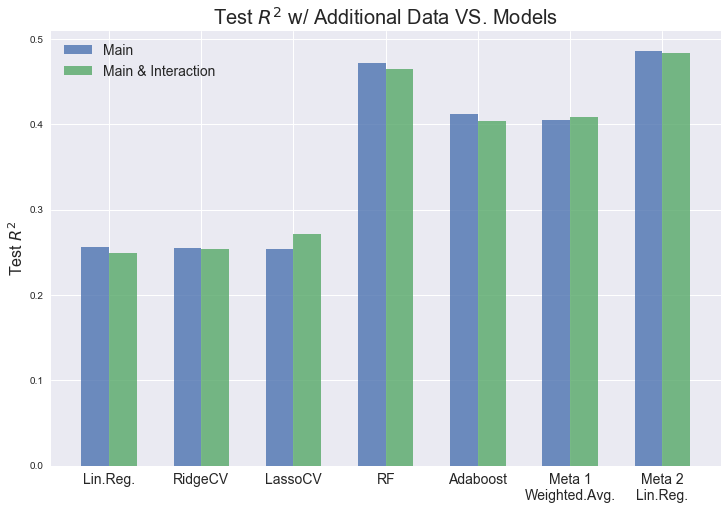

In [47]:
# Visualize the Test R^2 scores of all models
model_names = ['Lin.Reg.', 'RidgeCV', 'LassoCV', 'RF', 'Adaboost', 'Meta 1\nWeighted.Avg.', 'Meta 2\nLin.Reg.']
acc_test_main = [0.25624, 0.25464, 0.25393, 0.47226, 0.41227, 0.40447, 0.48533]
acc_test_int = [0.24970, 0.25436, 0.27189, 0.46527, 0.40371, 0.40797, 0.48341]

width = 0.3
plt.figure(figsize=(12, 8))
plt.bar(np.arange(len(model_names)), acc_test_main, width, alpha=0.8, label='Main')
plt.bar(np.arange(len(model_names))+width, acc_test_int, width, alpha=0.8, label='Main & Interaction')
plt.xticks(np.arange(len(model_names))+0.5*width, model_names, fontsize=14)
plt.title('Test $R^2$ w/ Additional Data VS. Models ', fontsize=20)
plt.ylabel('Test $R^2$', fontsize=16)
plt.legend(fontsize=14)
plt.show()